In [1]:
import sys
sys.path.append("/home1/09528/amoac/simulations_code/") 
import gizmo_analysis as gizmo 
import utilities as ut
#from fof_analysis import fof
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from matplotlib import rc #to use Latex math symbols like 'phi'
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from astropy.table import Table
from astropy.io import ascii
import pickle


b_parsec    = 4
b_kpc       = b_parsec / 1000.
ncut_min    = 5
age_cut_Myr = 3 #Myr
age_cut_Gyr = age_cut_Myr / 1000. #Gyr
softening   = 4. #res 7100
snaps = [622] #set snaps to an arrange of values, goes from 621 to but not including 624 going up by 1

simname     = 'm12m_res7100'
simdir      = '/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12m_r7100/1Myr'

part = gizmo.io.Read.read_snapshots(['star'],'index', snaps[0], simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)
print
pkl_path = '/home1/09528/amoac'
filename = pkl_path + '/' + 'm12m_' + str(622) + '_cluster.pkl'
with open(filename, 'rb') as handle: 
    cl_id = pickle.load(handle)
    
cloud_path = '/home1/09528/amoac/'
data = ascii.read(cloud_path + 'cloud_props_m12m_1Myr622.txt')
idata = ascii.read(cloud_path + 'cloud_indices_m12m_1Myr622.txt')

MsunToGm = 1.99e33
KpcToCm = 3.086e21
mp = 1.67e-24
#bin_edge = 10.
bin_edge = 20.
##gas properties to carry around

xg = []
yg = []
zg = []
vxg = []
vyg = []
vzg = []
mg = []
rhog = []
tg = []
idg = []

xs = []
ys = []
zs = []
ms = []
ids = []
    
#star properties to carry around

sxp = []
syp = []
szp = []
sxp_new = []
syp_new = []
szp_new = []
sage = []

gxp = []
gyp = []
gzp = []

vdispx = []
vdispy = []
vdispz = []

#snaps = np.arange(622)
#cl_id = pickle.load(open(m12m_622_cluster.pkl,'rb'))

sxcm = np.zeros(shape=(len(snaps),len(cl_id)))
sycm = np.zeros(shape=(len(snaps),len(cl_id)))
szcm = np.zeros(shape=(len(snaps),len(cl_id)))
ap_num = np.zeros(shape=(len(snaps),len(cl_id)))

r_ap = 0.05

point_gas = []

#snap time
tsnap = [] 

############################################################################
#read in sim files and find relevant particles
############################################################################

for i in range(len(snaps)):
    #/home/smbeninc/scr/m12m/m12m_res7100/
    #part = gizmo.io.Read.read_snapshots('all', 'snapshot_index', snaps[i],assign_host_principal_axes=True)

    part = gizmo.io.Read.read_snapshots(['star','gas'],'index', snaps[0], simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)
    
    tsnap.append(np.max(part['star'].prop('form.time')))

    ig = np.where((part['gas'].prop('host.distance.principal.cylindrical')[:,0] <= bin_edge) & (np.fabs(part['gas'].prop('host.distance.principal.cartesian')[:,2]) <= 1.5) & (part['gas']['temperature'] <= 1e4))
    
    ist = np.where((part['star'].prop('host.distance.principal.cylindrical')[:,0] <= bin_edge) & (np.fabs(part['star'].prop('host.distance.principal.cartesian')[:,2]) <= 1.5))
    
    xg.append(part['gas'].prop('host.distance.principal.cartesian')[ig[0],0])
    yg.append(part['gas'].prop('host.distance.principal.cartesian')[ig[0],1])
    zg.append(part['gas'].prop('host.distance.principal.cartesian')[ig[0],2])
    
    vxg.append(part['gas'].prop('host.velocity.principal.cartesian')[ig[0],0])
    vyg.append(part['gas'].prop('host.velocity.principal.cartesian')[ig[0],1])
    vzg.append(part['gas'].prop('host.velocity.principal.cartesian')[ig[0],2])
    
    mg.append(part['gas']['mass'][ig])
    rhog.append(part['gas'].prop('number.density')[ig])
    tg.append(part['gas']['temperature'][ig])
    idg.append(part['gas']['id'][ig])
    
    xs.append(part['star'].prop('host.distance.principal.cartesian')[ist[0],0])
    ys.append(part['star'].prop('host.distance.principal.cartesian')[ist[0],1])
    zs.append(part['star'].prop('host.distance.principal.cartesian')[ist[0],2])
    ms.append(part['star']['mass'][ist])
    ids.append(part['star']['id'][ist])
    sage.append(part['star'].prop('age')[ist]*1000.)
        
    msh = np.array(ms[i])
    xsh = np.array(xs[i])
    ysh = np.array(ys[i])
    zsh = np.array(zs[i])

    mgh = np.array(mg[i])
    xgh = np.array(xg[i])
    ygh = np.array(yg[i])
    zgh = np.array(zg[i])

    vxgh = np.array(vxg[i])
    vygh = np.array(vyg[i])
    vzgh = np.array(vzg[i])
    for j in range(len(cl_id)):
        cl = cl_id[j]
        ind = []
        check = []
        print(j, ind, check)
        for k in range(len(cl)):
            ind.append(np.where(cl[k] == ids[i])[0])
            check.append(len(ind[k]))
        ind = np.array(ind, dtype=object)
        ind2 = np.array(ind[np.where(np.array(check) == 1)[0]])
        ind2 = ind2.astype(dtype='int') 
        sxcm[i,j] = np.sum(msh[ind2]*xsh[ind2])/np.sum(msh[ind2])
        sycm[i,j] = np.sum(msh[ind2]*ysh[ind2])/np.sum(msh[ind2])
        szcm[i,j] = np.sum(msh[ind2]*zsh[ind2])/np.sum(msh[ind2])
        sxp.append(xsh[ind2])
        syp.append(ysh[ind2])
        szp.append(zsh[ind2])

        rh = np.sqrt((xgh-sxcm[i,j])**2 + (ygh-sycm[i,j])**2 + (zgh-szcm[i,j])**2)
        rsh = np.sqrt((xsh-sxcm[i,j])**2 + (ysh-sycm[i,j])**2 + (zsh-szcm[i,j])**2)
        ind = np.where(rh <= r_ap)
        n = float(len(ind[0]))

        indst = np.where((rsh <= r_ap) & (sage[i] <= float(i)*2.2))
        gxp.append(xgh[ind])
        gyp.append(ygh[ind])
        sxp_new.append(xsh[indst])
        syp_new.append(ysh[indst])
        if (len(ind[0]) > 0):
            vmean = np.average(vxgh[ind],weights=mgh[ind])
            vdispx.append(np.sqrt(np.sum(mgh[ind]*(vxgh[ind]-vmean)**2)/ ((n-1)*np.sum(mgh[ind])/n)))
            vmean = np.average(vygh[ind],weights=mgh[ind])
            vdispy.append(np.sqrt(np.sum(mgh[ind]*(vygh[ind]-vmean)**2)/ ((n-1)*np.sum(mgh[ind])/n)))
            vmean = np.average(vzgh[ind],weights=mgh[ind])
            vdispz.append(np.sqrt(np.sum(mgh[ind]*(vzgh[ind]-vmean)**2)/ ((n-1)*np.sum(mgh[ind])/n)))
        else:
            vdispx.append(0.)
            vdispy.append(0.)
            vdispz.append(0.)
            
######compare to clouds & track clouds
#which cluster at 591 to focus on
#focus_list = [4, 9, 13, 16, 17, 27, 53, 63, 65, 67, 70, 74, 82, 83]
#focus = 83

#focus = 13
#focus_list = [13,13]
focus_list = np.arange(1,2,1)
#focus_list = np.arange(len(cl_id))
#focus_list = [1,38]

alpha_track = np.zeros(shape=(3,len(cl_id)))
alpha_s_track = np.zeros(shape=(3,len(cl_id)))
vdisp_track = np.zeros(shape=(3,len(cl_id)))
mass_track = np.zeros(shape=(3,len(cl_id)))
xcm_track = np.zeros(shape=(3,len(cl_id)))
ycm_track = np.zeros(shape=(3,len(cl_id)))
zcm_track = np.zeros(shape=(3,len(cl_id)))

#data0 = ascii.read('cloud_props_m12m_622.txt')
#idata0 = ascii.read('cloud_indices_m12m_.txt')

data = ascii.read(cloud_path + 'cloud_props_m12m_1Myr622.txt')
idata = ascii.read(cloud_path + 'cloud_indices_m12m_1Myr622.txt')

#data2 = ascii.read('cloud_props_m12m_592.txt')
#idata2 = ascii.read('cloud_indices_m12m_592.txt')



# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12m_r7100/1Myr/snapshot_times.txt

  using snapshot index = 622, redshift = 0.005


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12m_r7100/1Myr/output/snapdir_622/snapshot_622.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 140876456 particles
    dark2     (id = 2): 10063684 particles
    gas       (id = 0): 116800727 particles
    star      (id = 4): 25286033 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_622.0.hdf5
    snapshot_622.1.hdf5
    snapshot_622.2.hdf5
    snapshot_622.3.hdf5
    snapshot_622.4.hdf5
    snapshot_622.5.hdf5
    snapshot_622.6.hdf5
    snapshot_622.7.hdf5

! cannot find MUSIC config file:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12m_r7100/1Myr/*/*.co

NameError: name 'w' is not defined

dict_keys(['star', 'gas'])


In [11]:
######compare to clouds & track clouds
#which cluster at 591 to focus on
focus_list = np.arange(0,18,1)
focus = 0

#focus = 13
#focus_list = [13,13]
#focus_list = np.arange(1,2,1)
#focus_list = np.arange(len(cl_id))
#focus_list = [1,38]


#print(len(focus_list))
#print(len(cl_id[0]))
#print(data['cloud number'])
#print(data.keys())


alpha_track = np.zeros(shape=(3,len(cl_id)))
alpha_s_track = np.zeros(shape=(3,len(cl_id)))
vdisp_track = np.zeros(shape=(3,len(cl_id)))
mass_track = np.zeros(shape=(3,len(cl_id)))
xcm_track = np.zeros(shape=(3,len(cl_id)))
ycm_track = np.zeros(shape=(3,len(cl_id)))
zcm_track = np.zeros(shape=(3,len(cl_id)))

#print(xcm_track[0])
#print(xcm_track[0][0])
#print(sxcm[0])
#print(sxcm[0][0])

for focus in focus_list:
    #load in the cloud catalogs
    ##########find the original cloud
    #xh = sxcm[1,focus]
    #yh = sycm[1,focus]
    #zh = szcm[1,focus]
    
    xh = sxcm[0][focus]
    yh = sycm[0][focus]
    zh = szcm[0][focus]
    
    #print(xh)
    #print(yh)
    #print(zh)
   # print(data['xcm'])
    
    distx = np.array(data['xcm']) - xh
    disty = np.array(data['ycm']) - yh
    distz = np.array(data['zcm']) - zh
    dist = np.sqrt(distx**2 + disty**2 + distz**2)
    
    #print(np.where(dist == min(dist))[0])
          
    focus_cl = np.where(dist == min(dist))[0]
    focus_cl_m = data['mass'][np.where(data['cloud number'] == focus_cl)]
    
    cluster_gas = idata['id'][np.where(idata['cloud number'] == focus_cl)[0]]
    
    evolve = []
    evolve_mass = []
    
    for i in range(len(cluster_gas)):
        if (len(np.where(idata['id'] == cluster_gas[i])[0]) == 1):
            evolve.append(idata['cloud number'][np.where(idata['id'] == cluster_gas[i])[0]])
            evolve_mass.append(float(idata['mass'][np.where(idata['id'] == cluster_gas[i])[0]]))
        if (len(np.where(idata['id'] == cluster_gas[i])[0]) == 2):
            dists = np.sqrt((idata['x'][np.where(idata['id'] == cluster_gas[i])[0]]-xh)**2 + (idata['y'][np.where(idata['id'] == cluster_gas[i])[0]]-yh)**2 + (idata['z'][np.where(idata['id'] == cluster_gas[i])[0]]-zh)**2)
            evolve.append(idata['cloud number'][np.where(idata['id'] == cluster_gas[i])[0][np.where(dists == np.min(dists))]])
            evolve_mass.append(float(idata['mass'][np.where(idata['id'] == cluster_gas[i])[0][np.where(dists == np.min(dists))]]))
    
    evolve = np.array(evolve)
    evolve_mass = np.array(evolve_mass)
    unq = np.unique(evolve)
    unq_mass = np.zeros(len(unq))
    
    for i in range(len(unq)):
        k = np.where(evolve == unq[i])[0]
        unq_mass[i] = np.sum(evolve_mass[k])

    if (len(unq_mass) > 0):
        match = np.where(unq_mass == np.max(unq_mass))
        evolve_cl = unq[match]
        evolve_cl_m = unq_mass[match][0]
        evolve_cl_mtot = data['mass'][np.where(data['cloud number'] == evolve_cl)]
        ratio = evolve_cl_m/focus_cl_m
    else:
        ratio = 0.
    mass_track[0,focus] = data['mass'][np.where(data['cloud number'] == focus_cl)]
    alpha_track[0,focus] = data['alpha_vir'][np.where(data['cloud number'] == focus_cl)]
    vdisp_track[0,focus] = np.sqrt(data['vdisp_x'][np.where(data['cloud number'] == focus_cl)]**2 + data['vdisp_y'][np.where(data['cloud number'] == focus_cl)]**2 + data['vdisp_z'][np.where(data['cloud number'] == focus_cl)]**2)/np.sqrt(3.)
    xcm_track[0][focus] = data['xcm'][np.where(data['cloud number'] == focus_cl)]
    ycm_track[0][focus] = data['ycm'][np.where(data['cloud number'] == focus_cl)]
    zcm_track[0][focus] = data['zcm'][np.where(data['cloud number'] == focus_cl)]


#print(idata.keys)
    #cut and past this stuff
##calculated distance between cluster and closest cloud. Change 'cl' to cloud
    
    

In [23]:
#image some stuff
bin_edge = 0.5
sizebox = bin_edge*2.
stepn = 30 #no clue what this is for

count = 0
htot = 0.
w2d_kernel = []
nkernel = 200
w2d_table = np.zeros(nkernel+3)

vel_array0 = np.zeros(shape=(2,stepn, stepn))
vel_array1 = np.zeros(shape=(2,stepn, stepn))
vel_array2 = np.zeros(shape=(2,stepn, stepn))


#read the kernel file
kernelfile = 'kernel2d'
temp = open(kernelfile,'r').read().split('\n')

for i in range(len(temp)-1):
    if (i%2 == 0):
        w2d_kernel.append(float(temp[i]))

w2d_kernel.append(0.)
w2d_kernel = np.array(w2d_kernel)

stepnh= (stepn-1)/2
res= sizebox/stepn
print('stepnh = ', stepnh)
print('res = ', res)

#focus = 38
focus = 0

for t in range(len(snaps)):
    w2darray = np.zeros(shape=(stepn, stepn))
    vel_array = np.zeros(shape=(stepn, stepn))
    xcen = xcm_track[t][focus]
    ycen = ycm_track[t][focus]
    zcen = zcm_track[t][focus]
    
    #read in sim snap
    part = gizmo.io.Read.read_snapshots(['star','gas'],'index', snaps[0], simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)
    #part = gizmo.io.Read.read_snapshots('all', 'snapshot_index', snaps[t],assign_host_principal_axes=True)
    
    ig = np.where((part['gas'].prop('host.distance.principal.cartesian')[:,0] <= (xcen + bin_edge)) & (part['gas'].prop('host.distance.principal.cartesian')[:,0] > (xcen - bin_edge)) &  (part['gas'].prop('host.distance.principal.cartesian')[:,1] > (ycen - bin_edge)) & (part['gas'].prop('host.distance.principal.cartesian')[:,1] <= (ycen + bin_edge)) & (np.fabs(part['gas'].prop('host.distance.principal.cartesian')[:,2]) <= 1.5))
    ngas = len(ig[0])
    
    #ig = np.where((part['gas'].prop('host.distance.principal.cartesian')[:,0] <= (xcen + bin_edge)) & (part['gas'].prop('host.distance.principal.cartesian')[:,0] > (xcen - bin_edge)) &  (part['gas'].prop('host.distance.principal.cartesian')[:,1] > (ycen - bin_edge)) & (part['gas'].prop('host.distance.principal.cartesian')[:,1] <= (ycen + bin_edge)) & (np.fabs(part['gas'].prop('host.distance.principal.cartesian')[:,2]) <= 1.5))
    #ngas = len(ig[0])
    xg = part['gas'].prop('host.distance.principal.cartesian')[ig[0],0]
    yg = part['gas'].prop('host.distance.principal.cartesian')[ig[0],1]
    zg = part['gas'].prop('host.distance.principal.cartesian')[ig[0],2]
    mg = part['gas']['mass'][ig]
    print(part['gas'].keys())
    #hg = part['gas']['smooth.length'][ig]
    hg = np.zeros(len(ig[0])) + 2
    #set the kernel weights, make sure to normalize properly
    for i in range(ngas):
        htot = htot + hg[i]/ngas
        
        
    ##big loop
    for i in range(ngas):
        xi = (xg[i]-xcen)/res+stepnh
        yi = (yg[i]-ycen)/res+stepnh
        hi = 2*hg[i]/res
        
        ixmin= np.int(np.floor(xi-hi))+1
        if (ixmin < 0):
            ixmin=0
        if (ixmin > stepn-1):
            ixmin=stepn-1
        ixmax= np.int(np.floor(xi+hi))
        if (ixmax > stepn-1):
            ixmax=stepn-1
        if (ixmax < 0):
            ixmax=0
        iymin= np.int(np.floor(yi-hi))+1
        if (iymin < 0):
            iymin=0
        if (iymin > stepn-1):
            iymin=stepn-1
        iymax= np.int(np.floor(yi+hi))
        if (iymax > stepn-1):
            iymax=stepn-1
        if (iymax < 0):
            iymax=0
            
        if (i%1000 == 0):
            print("Doing particle: ",i,ngas)
            
        count = count + 1
        w2d_sum = 0.
        d2max = 4.*hg[i]*hg[i]
        kernfrac = nkernel*.5/hg[i]
        loop = np.arange(ixmin,ixmax+1,1)
        for ii in range(len(loop)):
            r0xx = (ii - stepnh)*res + xcen
            for jj in range(len(loop)):
                r0yy = (jj-stepnh)*res + ycen
                xx = xg[i] - r0xx
                yy = yg[i] - r0yy
                d2 = xx*xx + yy*yy
                if (d2 <= d2max):
                    d = np.sqrt(d2)
                    xii = d*kernfrac
                    xxi = np.int(np.floor(xii))
                    w2d= ((w2d_table[xxi+1] - w2d_table[xxi])*(xii - xxi)+ w2d_table[xxi])
                    w2darray[ii,jj] = w2d
                    w2d_sum = w2d_sum + w2d
                else:
                    w2darray[ii,jj] = 0.
        if (w2d_sum > 0):
            weight = mg[i]/w2dsum
            for ii in range(len(loop)):
                for jj in range(len(loop)):
                    if (w2darray[ii,jj] > 0):
                        vel_array[ii,jj] = vel_array[ii,jj] + w2darray[ii,jj]*weight
        else:
            ii = np.int(np.floor(xi + 0.5))
            jj = np.int(np.floor(yi + 0.5))
            if ((ii >=0) & (ii <= stepn-1) & (jj >= 0) & (jj <= stepn-1)):
                vel_array[ii,jj] = vel_array[ii,jj] + mg[i]

    if (t == 0):
        vel_array0[0,:,:] = vel_array
    if (t == 1):
        vel_array1[0,:,:] = vel_array
    if (t == 2):
        vel_array2[0,:,:] = vel_array

stepnh =  14.5
res =  0.03333333333333333

# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12m_r7100/1Myr/snapshot_times.txt

  using snapshot index = 622, redshift = 0.005


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12m_r7100/1Myr/output/snapdir_622/snapshot_622.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 140876456 particles
    dark2     (id = 2): 10063684 particles
    gas       (id = 0): 116800727 particles
    star      (id = 4): 25286033 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'gas']

* reading particles from:
    snapshot_622.0.hdf5
    snapshot_622.1.hdf5
    snapshot_622.2.hdf5
    snapshot_622.3.hdf5
    snapshot_622.4.hdf5
    snapshot_622.5.hdf5
    snapshot_622.6.hdf5
    snapshot_622.7.hdf5

! cannot find MUSIC config file:  scratch/projects/xsede/Gala

<ipython-input-23-96e562336070>:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ixmin= np.int(np.floor(xi-hi))+1
<ipython-input-23-96e562336070>:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for m

Doing particle:  1000 2526
Doing particle:  2000 2526


<ipython-input-24-aa68a85e07b4>:12: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax0.imshow(vel_array0[0,:,:]/((res*1000.)**2), interpolation='gaussian',norm=colors.LogNorm(),vmin=1,vmax=1000,extent=(xcm_track[0,1]-0.5,xcm_track[0,1]+0.5,ycm_track[0,1]-0.5,ycm_track[0,1]+0.5))
<ipython-input-24-aa68a85e07b4>:13: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax1.imshow(vel_array1[0,:,:]/((res*1000.)**2), interpolation='gaussian',norm=colors.LogNorm(),vmin=1,vmax=1000,extent=(xcm_track[1,1]-0.5,xcm_track[1,1]+0.5,ycm_track[1,1]-0.5,ycm_track[1,1]+0.5))
<ipython-input-24-aa68a85e07b4>:14: MatplotlibDeprecationWarning: Passing parameters norm an

IndexError: list index out of range

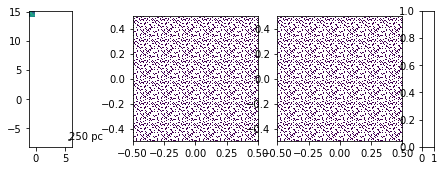

In [24]:
fig = plt.figure(figsize=(8,2.5))

gs0 = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.1])
#gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0],wspace=0.05)
#gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1],wspace=0.05)

ax0 = plt.subplot(gs0[0])
ax1 = plt.subplot(gs0[1])
ax2 = plt.subplot(gs0[2])
axcb = plt.subplot(gs0[3])

ax0.imshow(vel_array0[0,:,:]/((res*1000.)**2), interpolation='gaussian',norm=colors.LogNorm(),vmin=1,vmax=1000,extent=(xcm_track[0,1]-0.5,xcm_track[0,1]+0.5,ycm_track[0,1]-0.5,ycm_track[0,1]+0.5))
ax1.imshow(vel_array1[0,:,:]/((res*1000.)**2), interpolation='gaussian',norm=colors.LogNorm(),vmin=1,vmax=1000,extent=(xcm_track[1,1]-0.5,xcm_track[1,1]+0.5,ycm_track[1,1]-0.5,ycm_track[1,1]+0.5))
ax2.imshow(vel_array2[0,:,:]/((res*1000.)**2), interpolation='gaussian',norm=colors.LogNorm(),vmin=1,vmax=1000,extent=(xcm_track[2,1]-0.5,xcm_track[2,1]+0.5,ycm_track[2,1]-0.5,ycm_track[2,1]+0.5))

ax0.plot([5.65,5.65+0.25],[-7.05,-7.05],color='k',linewidth=1.5)
ax0.text(5.625,-7,'250 pc')

#plot the stars
ax1.scatter(sxp[1+len(cl_id)], syp[1+len(cl_id)], s=8,marker='*', edgecolors='k',facecolors='none',linewidth=0.5)
ax1.scatter(sxp[37+len(cl_id)], syp[37+len(cl_id)], s=8,marker='*',edgecolors='k',facecolors='none',linewidth=0.5)
ax1.scatter(sxp[54+len(cl_id)], syp[54+len(cl_id)], s=8,marker='*', edgecolors='k',facecolors='none',linewidth=0.5)
ax1.scatter(sxp[73+len(cl_id)], syp[73+len(cl_id)], s=8,marker='*', edgecolors='k',facecolors='none',linewidth=0.5)

ax2.scatter(sxp[1+2*len(cl_id)], syp[1+2*len(cl_id)], s=8,marker='*', edgecolors='k',facecolors='none',linewidth=0.5)
ax2.scatter(sxp[37+2*len(cl_id)], syp[37+2*len(cl_id)], s=8,marker='*', edgecolors='k',facecolors='none',linewidth=0.5)
ax2.scatter(sxp[54+2*len(cl_id)], syp[54+2*len(cl_id)], s=8,marker='*', edgecolors='k',facecolors='none',linewidth=0.5)
ax2.scatter(sxp[73+2*len(cl_id)], syp[73+2*len(cl_id)], s=8,marker='*', edgecolors='k',facecolors='none',linewidth=0.5)




#ax11.scatter(sxcm[1,1],sycm[1,1],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)
#ax11.scatter(sxcm[1,37],sycm[1,37],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)
#ax11.scatter(sxcm[1,54],sycm[1,54],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)
#ax11.scatter(sxcm[1,73],sycm[1,73],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)

#ax12.scatter(sxcm[2,1],sycm[2,1],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)
#ax12.scatter(sxcm[2,37],sycm[2,37],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)
#ax12.scatter(sxcm[2,54],sycm[2,54],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)
#ax12.scatter(sxcm[2,73],sycm[2,73],marker='o',s=80,edgecolors='k',facecolors='none',linewidth=0.75)

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

norm1 = matplotlib.colors.LogNorm(vmin=1,vmax=1000)
cb = matplotlib.colorbar.ColorbarBase(axcb,norm=norm1)
cb.set_label('$\Sigma$ (M$_{\odot}$/pc$^2$)')

ax0.set_title(r'$t_0$')
ax1.set_title(r'$t_1$')
ax2.set_title(r'$t_2$')

plt.savefig('andrew_gmc_cluster.pdf',bbox_inches='tight') 
plt.close(fig)
